<a href="https://colab.research.google.com/github/zuobinxiong/CS789/blob/main/Lab3_Defense_Adversarial_Attacks_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


The MNIST dataset contains data for all of the digits.

We need to normalize the data. Here, we use the API from `ART`.

Load the actual data. It will load the data as numpy array.

In [ ]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

In [ ]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format
# insert your code here
x_train = ...
x_test = ...

In [ ]:
print(type(x_train))
print(x_train.shape, x_test.shape, y_train.shape)

<class 'numpy.ndarray'>
(60000, 1, 28, 28) (10000, 1, 28, 28) (60000, 10)


We are using a very simple CNN. This network can be used to distinguish between all 10 classes with very high accuracy.

> Indented block



In [ ]:
# define the classifier
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


Then, we initialize a model and train with the cross-entropy loss.

To simplify the training code, we use the wrapper `PyTorchClassifier` from `ART` to train the model.

In [ ]:
# Step 2: Create the model

model = Net()

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)


In [ ]:
# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=10)

# Step 5: Evaluate the ART classifier on benign test examples
# insert your code here
predictions = ...
accuracy = ...
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 98.14%


We want to know how robust our model is against an attack. To do this we are calculating the empirical robustness. This is equivalent to computing the minimal perturbation that the attacker must introduce for a successful attack. We are following the approach of Moosavi-Dezfooli et al. 2016 (paper link: https://arxiv.org/abs/1511.04599).

The emperical robustness method supports two attacks at the moment. The Fast Gradient Sign Method and Hop Skip and Jump.

You can use them by passing either fgsm or hsj as parameters. The default attack parameters are the following:
```
    "fgsm":{"eps_step": 0.1, "eps_max": 1., "clip_min": 0., "clip_max": 1.},
    "hsj" {'max_iter': 50, 'max_eval': 10000, 'init_eval': 100, 'init_size': 100}
```

In [ ]:
from art.metrics import empirical_robustness
print( 'robustness of the undefended model', empirical_robustness( classifier, x_test, 'fgsm'))

robustness of the undefended model 0.13336396


In [ ]:
# the device(cpu/gpu) of the model
device = next(model.parameters()).device
device

device(type='cuda', index=0)

Let's use `ART` library to do the actual attack.

We will also use the FGSM attack to generate an adversarial example.

In [ ]:
# Generate adv examples with ART (FGSM attack)
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on clean test examples: {}%".format(accuracy * 100))

from art.attacks.evasion import FastGradientMethod
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples
# insert your code here

predictions = ...
accuracy = ...
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on clean test examples: 98.14%
Accuracy on adversarial test examples: 45.12%


In [ ]:
type(classifier)

art.estimators.classification.pytorch.PyTorchClassifier

logits for our sample: 	
 [[-1.3971952  3.06427   -3.6233103 -5.062901   0.5226361  3.3099189
  -1.1195996 -3.1394494 -1.4826114 -7.353565 ]]
predicted as [5]


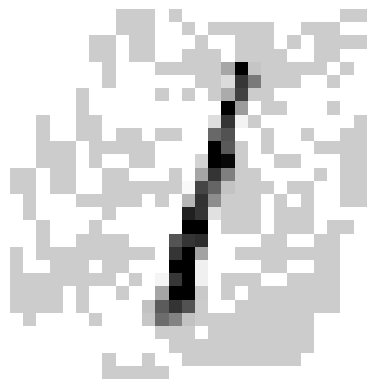

In [ ]:
# Visualize one example
x_test_adv = attack.generate(x=x_test[2])
print( 'logits for our sample: \t\n', classifier.predict( x_test_adv ) )
# print( 'class prediction for our sample: \t\n', F.softmax( model( x_test_adv ), dim=1 ).detach()  )
print( 'predicted as', np.argmax( classifier.predict( x_test_adv ) , axis=1) )

plt.imshow( x_test_adv.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

In [ ]:
# Evaluate
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

print("Accuracy on clean test examples: {}%".format(accuracy * 100))

# insert your code here for ProjectedGradientDescent attack (params: "estimator=", "max_iter=")

from art.attacks.evasion import ProjectedGradientDescent
attack = ...
x_test_adv = ...

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))



PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

logits for our sample: 	
 [[-18.136005  -4.263644 -21.47064  -24.807365  25.250463 -29.763885
  -24.986778   2.180322 -25.323313 -11.397535]]
predicted as [4]


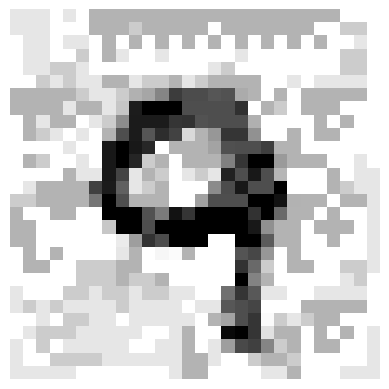

In [ ]:
# Visualize one example
x_test_adv = attack.generate(x=x_test[99])
print( 'logits for our sample: \t\n', classifier.predict( x_test_adv ) )
# print( 'class prediction for our sample: \t\n', F.softmax( model( x_test_adv ), dim=1 ).detach()  )
print( 'predicted as', np.argmax( classifier.predict( x_test_adv ) , axis=1) )

plt.imshow( x_test_adv.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

## Adversarial Training

Let's create a new untrained model with the same architecture that we have been using so far.

We will train the model using adversarial training framework. The idea is very simple:

1.   Train the model for 1 epoch
2.   Create adversarial examples using FGSM
3.   Enhance training data by mixing it with the adversarial examples. (Only mix in the adversarial examples created in this iteartion)
4.   Goto 1

We will be using the FGSM attack from `art` this time.




In [ ]:
# create a new untrained model and wrap it with PytorchClassifier
# insert your code here

model_1=...

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.01)

defended_model = PyTorchClassifier(...

)


In [ ]:
def accuracy(model, x, y):
    predictions = model.predict(x)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y, axis=1)) / len(y)
    print("Accuracy on test examples: {}%".format(accuracy * 100))

In [ ]:
# define the attack we are using
fgsm_attack = FastGradientMethod(estimator=defended_model, eps=0.2 )

# parameters
epochs = 5 # number of iterations that we will perform training for
ratio = 0.5  # ratio of the test set that will get turned into adversarial examples
            # each iteration

# some helpers
idx = np.arange( x_train.shape[ 0 ], dtype=np.int )

# create varialbes to hold the training data.
# for now it is just the normal training data. we'll mix in the
# adversarial examples in later
x_train_enhanced = x_train
y_train_enhanced = y_train


<ipython-input-28-de274c30b7ff>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.arange( x_train.shape[ 0 ], dtype=np.int )


In [ ]:
# Adversarial training process
for i in range( epochs ):
  # insert your code here
  # train model for one epoch
  ...
  # shuffle dataset index (idx) for randomly taking out a portion of data
  ...
  # pick the subest of the train data to turn into adverarial examples
  x_train_ = ...
  y_train_ = ...

  # create adversarial examples
  x_adv = ...

  # add the adversarial examples to the training data
  x_train_enhanced = ...
  y_train_enhanced = ...

In [ ]:
# test accuracy of adversarially trained model
# insert your code here
accuracy(...)

Accuracy on clean test examples: 97.92%


In [ ]:
# test accurac now on adversarial examples
# insert your code here

# generate some adv example from method FGSM
x_test_adv = ...
accuracy(defended_model,x_test_adv,y_test)

Accuracy on clean test examples: 69.51%


In [ ]:
# generate some adv example from method {PGD}
# insert your code here
pgd_attack = ...
x_test_adv = ...
accuracy(defended_model,x_test_adv,y_test)

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test examples: 2.01%


To use the adversarial training that comes with `art` we need to pass our wrapped model to an `AdversarialTrainer` instance. The `AdversarialTrainer` also needs an instance of the attack that will be used to create the adversarial examples.


In [ ]:
from art.defences.trainer import AdversarialTrainer

# get a new untrained model and warp it
model_art=Net()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_art.parameters(), lr=0.01)

defended_model_art = PyTorchClassifier(
    model=model_art,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# define the attack we are using
fgsm = FastGradientMethod( defended_model_art , eps=0.2 )
pgd_attack = ProjectedGradientDescent(estimator=defended_model, max_iter=20)

Create the `AdversarialTrainer` instance.
Train the model and evaluate it on the test data.

In [ ]:
# define the adversarial trainer and train the new network
# insert your code here
# AdversarialTrainer(params: "model", "list[attacks]")
adversarial_tranier = ...
adversarial_tranier.fit(...)

# evaluate how good our model is
accuracy(defended_model_art, x_test, y_test )

Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on test examples: 96.73%
Accuracy on test examples: 88.84%


In [ ]:
# Evaluate attacks now on adversarial examples
# insert your code here for fgsm attack and pgd attack
accuracy(defended_model_art, fgsm.generate(x_test), y_test )
accuracy(defended_model_art, pgd_attack.generate(x_test), y_test )

Accuracy on test examples: 88.84%
Accuracy on test examples: 94.46%


In [ ]:
from art.metrics import empirical_robustness
print( 'robustness of the undefended model', empirical_robustness( classifier, x_test, 'fgsm'))

print( 'robustness of the defended model', empirical_robustness( defended_model, x_test, 'fgsm'))

robustness of the undefended model 0.13336396
robustness of the defended model 0.15047292


## Defensive Distillation

In [ ]:
from torchvision import transforms,datasets

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])

train_set = datasets.MNIST(root = './data', train=True, transform = transform, download=True)

test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)

train_loader = torch.utils.data.DataLoader(train_set,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=64,shuffle=True)

In [ ]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [ ]:
# insert your code here, make a new and simple neural network, can be an MLP

class Net_simple(nn.Module):
  def __init__(self):
    super(Net_simple, self).__init__()
    ...

  def forward(self, x):
    ...
    return x


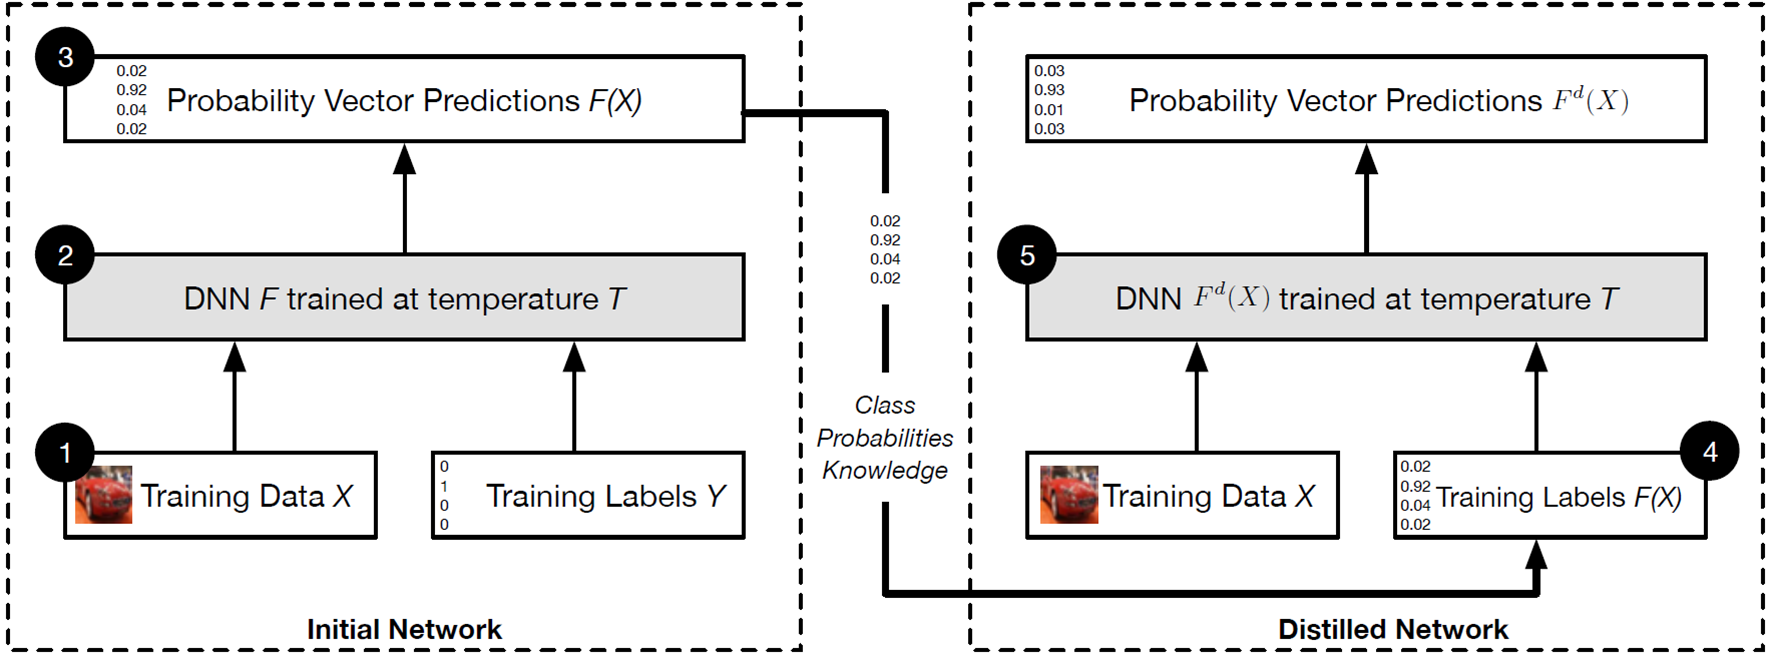

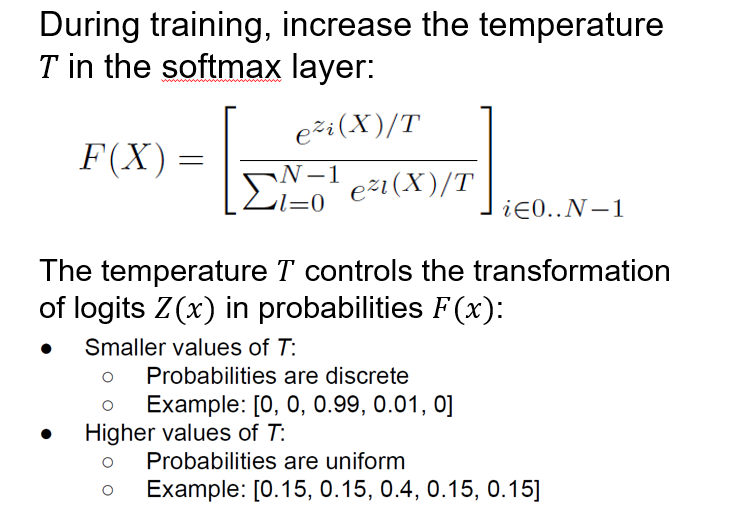

In [ ]:
model_dis = Net().to(device)

optimizer_dis = optim.Adam(model_dis.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion_dis = nn.NLLLoss()

In [ ]:
def fit(model, device, train_loader, epochs, Temp, criterion, optimizer):
  print("Fitting the model...")

  train_loss = []
# inser your code here for training with tempurature Temp
  for epoch in range(epochs):
      loss_per_epoch = 0
      for i,data in enumerate(train_loader):
        input,label  = data[0].to(device),data[1].to(device)
        # input to model
        output = ...
        # use tempurature effect
        output = ...
        #calculating loss on the output
        loss = ...
        # zero grad
        ...
        #grad calc w.r.t Loss func
        ...
        #update weights
        ...
        # cumulate loss
        loss_per_epoch+=loss.item()

      print("Epoch: {} Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader)))
      train_loss.append(loss_per_epoch/len(train_loader))
  plt.figure(figsize=(5,5))
  plt.plot(train_loss)
  plt.ylabel("loss")
  plt.show()
  return train_loss

Fitting the model...
Epoch: 1 Loss: 1.9805511928824728
Epoch: 2 Loss: 0.8374703594171671
Epoch: 3 Loss: 0.5889251105693866
Epoch: 4 Loss: 0.5031935246959169
Epoch: 5 Loss: 0.45026350817255884


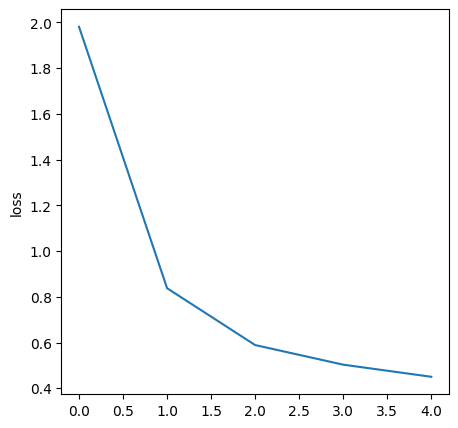

In [ ]:
# Train distillation model
train_loss=fit(model_dis, device, train_loader, 5, Temp=100, criterion=criterion_dis, optimizer=optimizer_dis)

In [ ]:
def test_accuracy(model,device,test_loader):
  correct = 0
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.max(1)[1]

      cur_cor = torch.sum(pred==target)
      correct+=cur_cor

  final_acc = correct/float(len(test_set))
  print("Test Accuracy = {} / {} = {}".format(correct, len(test_set), final_acc))

  return


In [ ]:
test_accuracy(model_dis,device, test_loader)

Test Accuracy = 8810 / 10000 = 0.8809999823570251


In [ ]:
# generating adversarial exmaples from model_dis (1st model)

classifier_dis = PyTorchClassifier(
    model=model_dis,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion_dis,
    optimizer=optimizer_dis,
    input_shape=(1, 28, 28),
    nb_classes=10,
)
attack = FastGradientMethod(estimator=classifier_dis, eps=0.05)
x_test_adv = attack.generate(x=x_test)
x_adv_ten=torch.tensor(x_test_adv)
pred=model_dis(x_adv_ten.to(device))
label = torch.tensor(y_test).to(device)

print("attack accuracy:",torch.sum(pred.max(1)[1]==label.max(1)[1])/float(y_test.shape[0]))


attack accuracy: tensor(0.8133)


In [ ]:
# generating adversarial exmaples from model_dis with PGD method

attack = ProjectedGradientDescent(estimator=classifier_dis, max_iter=20)
x_test_adv = attack.generate(x=x_test)
x_adv_ten=torch.tensor(x_test_adv)
pred=model_dis(x_adv_ten.to(device))
label = torch.tensor(y_test).to(device)

print("attack accuracy:",torch.sum(pred.max(1)[1]==label.max(1)[1])/float(y_test.shape[0]))


In [ ]:
model_new = Net_simple().to(device)
optimizer_new = optim.Adam(model_new.parameters(), lr=0.0001, betas=(0.9, 0.999))
criterion_new = nn.NLLLoss()

In [ ]:
def defense(device,train_loader,test_loader,epochs,Temp):

  model_dis.eval()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = ...
    softlabel  = ...
    data[1] = ...
    # print(data[1].shape)

  loss = fit(model_new, device, train_loader, epochs, Temp=100, criterion=criterion_new, optimizer=optimizer_new)

Fitting the model...
Epoch: 1 Loss: 2.204387103443715
Epoch: 2 Loss: 1.7768358027757103
Epoch: 3 Loss: 1.3372215734107662
Epoch: 4 Loss: 1.0549505744407426
Epoch: 5 Loss: 0.8840639612186693


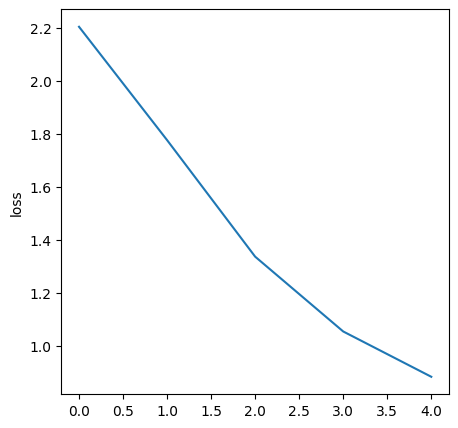

In [ ]:
defense(device,train_loader,test_loader,10,100)

In [ ]:
test_accuracy(model_new, device, test_loader)

Test Accuracy = 8055 / 10000 = 0.8054999709129333


In [ ]:
# generating adversarial exmaples from model_new (2st model)

classifier_new = PyTorchClassifier(
    model=model_new,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion_new,
    optimizer=optimizer_new,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

attack = FastGradientMethod(estimator=classifier_new, eps=0.05)
x_test_adv = attack.generate(x=x_test)
x_adv_ten=torch.tensor(x_test_adv)
pred=model_new(x_adv_ten.to(device))
label = torch.tensor(y_test).to(device)

print("attack accuracy:",torch.sum(pred.max(1)[1]==label.max(1)[1])/float(y_test.shape[0]))


In [ ]:
# generating adversarial exmaples from model_new (2st model) with another attack method

attack = ProjectedGradientDescent(estimator=classifier_new, max_iter=20)
x_test_adv = attack.generate(x=x_test)
x_adv_ten=torch.tensor(x_test_adv)
pred=model_new(x_adv_ten.to(device))
label = torch.tensor(y_test).to(device)

print("attack accuracy:",torch.sum(pred.max(1)[1]==label.max(1)[1])/float(y_test.shape[0]))
